In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from glob import glob

In [ ]:
batch_size = 512
epochs = 20
learning_rate = 1e-3

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

In [ ]:
# class AE(nn.Module):
#     def __init__(self, **kwargs):
#         super().__init__()
#         super(ConvAutoencoder, self).__init__()
#         ## encoder layers ##
#         # conv layer (depth from 1 --> 16), 3x3 kernels
#         self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
#         # conv layer (depth from 16 --> 4), 3x3 kernels
#         self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
#         # pooling layer to reduce x-y dims by two; kernel and stride of 2
#         self.pool = nn.MaxPool2d(2, 2)
        
#         ## decoder layers ##
#         ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
#         self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
#         self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


#         # super(ConvAutoencoder, self).__init__()
#         # # self.encoder_hidden_layer = nn.Conv2d(
#         # #     in_features=kwargs["input_shape"], out_features=128
#         # # )
#         # # self.encoder_hidden_layer = nn.Sequential(
#         # #     nn.Conv2d(1, 8, 3, stride=2, padding=1),
#         # #     nn.ReLU(True),
#         # #     nn.Conv2d(8, 16, 3, stride=2, padding=1),
#         # #     nn.BatchNorm2d(16),
#         # #     nn.ReLU(True),
#         # #     nn.Conv2d(16, 32, 3, stride=2, padding=0),
#         # #     nn.ReLU(True)
#         # #)
#         # # self.encoder_hidden_layer2 = nn.Conv2d(
#         # #     in_features=kwargs["input_shape"], out_features=128
#         # # )
#         # self.encoder_output_layer = nn.Linear(
#         #     in_features=128, out_features=128
#         # )
#         # self.decoder_hidden_layer = nn.Linear(
#         #     in_features=128, out_features=128
#         # )
#         # self.decoder_output_layer = nn.Linear(
#         #     in_features=128, out_features=kwargs["input_shape"]
#         )

#     def forward(self, features):
#         activation = self.encoder_hidden_layer(features)
#         activation = torch.relu(activation)
#         # activation = self.encoder_hidden_layer2(features)
#         # activation = torch.relu(activation)
#         code = self.encoder_output_layer(activation)
#         code = torch.sigmoid(code)
#         activation = self.decoder_hidden_layer(code)
#         activation = torch.relu(activation)
#         activation = self.decoder_output_layer(activation)
#         reconstructed = torch.sigmoid(activation)
#         return reconstructed

import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
# model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

In [ ]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

RuntimeError: ignored

In [ ]:
test_dataset = torchvision.datasets.FashionMNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)
test_dataset1 = test_dataset[0], test_dataset[1], test_dataset[2], test_dataset[3], test_dataset[4]

test_loader = torch.utils.data.DataLoader(
    test_dataset1, batch_size=5, shuffle=False
)

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784).to(device)
        reconstruction = model(test_examples)
        break



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/torch_datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/torch_datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/torch_datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/torch_datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/FashionMNIST/raw



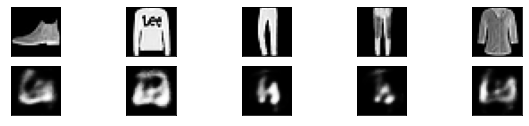

In [ ]:
with torch.no_grad():
    number = 5
    plt.figure(figsize=(10, 2))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()